In [2]:
import pandas as pd
import numpy as np
import requests
import time


In [3]:
pip install requests pandas tqdm


In [4]:
import pandas as pd

df = pd.read_csv("/content/Wallet id - Sheet1.csv")
wallets = df['wallet_id'].tolist()[:100]  # top 100 wallet


In [5]:
import requests
import time

API_KEY = "cqt_rQFKCgT6KYtJvrTh7HYxcDcpfyxb"  # Replace with your Covalent API Key
CHAIN_ID = 1  # Ethereum mainnet

all_data = {}

for wallet in wallets:
    url = f"https://api.covalenthq.com/v1/{CHAIN_ID}/address/{wallet}/transactions_v3/?key={API_KEY}"
    response = requests.get(url)

    if response.status_code == 200:
        all_data[wallet] = response.json()
    else:
        print(f"❌ Error for {wallet}: {response.status_code}")

    time.sleep(1.5)  # Respect API rate limits


Loop Through Wallets and Fetch Data:

In [6]:
import requests
import time

api_key = "cqt_rQFKCgT6KYtJvrTh7HYxcDcpfyxb"  # ← apna Covalent API key yahan daalo
base_url = "https://api.covalenthq.com/v1/eth-mainnet/address"

# Store data for all wallets
all_wallet_data = []

for wallet in wallets:
    url = f"{base_url}/{wallet}/transactions_v3/?key={api_key}"

    try:
        response = requests.get(url)
        if response.status_code == 200:
            data = response.json()
            transactions = data['data']['items']

            for tx in transactions:
                all_wallet_data.append({
                    'wallet_id': wallet,
                    'tx_hash': tx['tx_hash'],
                    'from_address': tx['from_address'],
                    'to_address': tx['to_address'],
                    'value': tx['value'],
                    'gas_spent': tx['gas_spent'],
                    'gas_price': tx['gas_price'],
                    'fees_paid': tx['fees_paid'],
                    'successful': tx['successful'],
                    'block_signed_at': tx['block_signed_at']
                })
        else:
            print(f"Error {response.status_code} for wallet {wallet}")

        # 🔁 Respect API rate limit (Covalent free tier is ~4/sec)
        time.sleep(0.3)

    except Exception as e:
        print(f"Error for wallet {wallet}: {str(e)}")


Convert to DataFrame (After Loop)

In [7]:
import pandas as pd

tx_df = pd.DataFrame(all_wallet_data)
print(tx_df.head())


                                    wallet_id  \
0  0x0039f22efb07a647557c7c5d17854cfd6d489ef3   
1  0x0039f22efb07a647557c7c5d17854cfd6d489ef3   
2  0x0039f22efb07a647557c7c5d17854cfd6d489ef3   
3  0x0039f22efb07a647557c7c5d17854cfd6d489ef3   
4  0x06b51c6882b27cb05e712185531c1f74996dd988   

                                             tx_hash  \
0  0x98703fb4a7c6804d82e98f009ecc0e089abd53de9469...   
1  0x0b8e89905717b9babd69aa7db6af0afb83331e9b8041...   
2  0x5745f6d2e9397ed8ceb7120f42761e1f04643e132e94...   
3  0x35cd404392ac9b7786bee78e4bfb2773cbb576b9c3dc...   
4  0x2ef861c6dee8c0e5b9a6a621d5b7b2a92cf841cd2c23...   

                                 from_address  \
0  0xc6b602de080fc9ac9d96a431b2d749d38e77cbbc   
1  0xfd0ce77ca6521e3cbbcfb07398cca8ec2648115d   
2  0xc07aff7c831105bacaf2fb4d9506332112eee2a1   
3  0xad38352c725c6768c11a9a71bc7d921a9355d56c   
4  0x06b51c6882b27cb05e712185531c1f74996dd988   

                                   to_address             value  gas_spen

In [8]:
# Convert to numeric (ETH units ya Wei units me)
tx_df['value'] = pd.to_numeric(tx_df['value'], errors='coerce')
tx_df['fees_paid'] = pd.to_numeric(tx_df['fees_paid'], errors='coerce')
tx_df['gas_price'] = pd.to_numeric(tx_df['gas_price'], errors='coerce')


Data Cleaning

In [9]:
df.isnull().sum()


,0
wallet_id,0


In [10]:
# Ye dekho: tumhara cleaned transaction data kis variable me store hai?
# Shayad tumne `df`, `tx_df`, `transactions_df`, etc. naam diya ho.

# Run karo sab variables ka list:
%whos DataFrame


Variable   Type         Data/Info
---------------------------------
df         DataFrame                             <...>n\n[103 rows x 1 columns]
tx_df      DataFrame                             <...>n[1747 rows x 10 columns]


In [11]:
# Check for null values
print(tx_df.isnull().sum())

# Remove duplicate rows if any
tx_df = tx_df.drop_duplicates()

# Convert 'block_signed_at' to datetime
tx_df['block_signed_at'] = pd.to_datetime(tx_df['block_signed_at'])

# Fill missing values in 'to_address' with 'Unknown'
tx_df['to_address'] = tx_df['to_address'].fillna('Unknown')


wallet_id           0
tx_hash             0
from_address        0
to_address         31
value               0
gas_spent           0
gas_price           0
fees_paid           0
successful          0
block_signed_at     0
dtype: int64


Fill missing with 'Unknown'

In [12]:
tx_df['to_address'] = tx_df['to_address'].fillna('Unknown')


Feature Engineering:

In [13]:
# Convert to datetime
tx_df['block_signed_at'] = pd.to_datetime(tx_df['block_signed_at'])

# Group and engineer features
features_df = tx_df.groupby('wallet_id').agg(
    num_txns=('tx_hash', 'count'),
    num_successful_txns=('successful', lambda x: x.sum()),
    num_failed_txns=('successful', lambda x: (~x).sum()),
    avg_tx_value=('value', 'mean'),
    total_value_sent=('value', 'sum'),
    total_fees_paid=('fees_paid', 'sum'),
    total_gas_spent=('gas_spent', 'sum'),
    avg_gas_price=('gas_price', 'mean'),
    num_unique_to_addresses=('to_address', pd.Series.nunique),
    active_days=('block_signed_at', lambda x: x.dt.date.nunique()),
    first_tx=('block_signed_at', 'min'),
    last_tx=('block_signed_at', 'max')
)

# Duration feature
features_df['activity_duration_days'] = (features_df['last_tx'] - features_df['first_tx']).dt.days
features_df.drop(['first_tx', 'last_tx'], axis=1, inplace=True)

# Reset index
features_df = features_df.reset_index()


In [14]:
features_df.head()

,wallet_id,num_txns,num_successful_txns,num_failed_txns,avg_tx_value,total_value_sent,total_fees_paid,total_gas_spent,avg_gas_price,num_unique_to_addresses,active_days,activity_duration_days
0,0x0039f22efb07a647557c7c5d17854cfd6d489ef3,4,4,0,0.000000e+00,0.000000e+00,11477582050000000,15759646,1.587500e+09,2,4,113
1,0x06b51c6882b27cb05e712185531c1f74996dd988,5,5,0,4.860370e+15,2.430185e+16,15559648000000000,308732,5.280000e+10,4,1,0
2,0x0795732aacc448030ef374374eaae57d2965c16c,4,4,0,4.650000e+15,1.860000e+16,15780978000000000,290793,5.850000e+10,3,1,0
3,0x0aaa79f1a86bc8136cd0d1ca0d51964f4e3766f9,80,80,0,2.523044e+18,2.018435e+20,1725902402924921473,132280277,3.998171e+10,56,57,2067
4,0x0fe383e5abc200055a7f391f94a5f5d1f844b9ae,5,5,0,5.200938e+15,2.600469e+16,14405516000000000,308720,5.214000e+10,4,2,63


Feature Scaling & Model Building

In [15]:
from sklearn.preprocessing import StandardScaler

# Select only numeric features (excluding wallet_id)
X = features_df.drop('wallet_id', axis=1)

# Initialize scaler and fit_transform
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


Find Optimal Number of Clusters (Elbow Method)

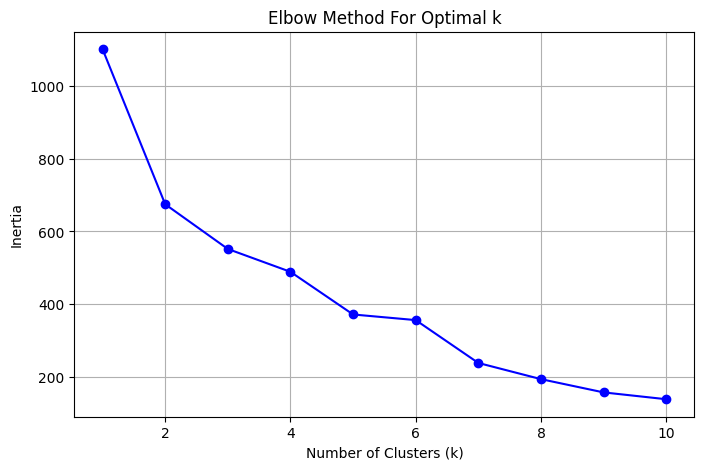

In [16]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Try k from 1 to 10
inertia = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.show()


Inertia drops steeply from k = 1 to k = 2

Then it gradually decreases after that

There’s a visible “elbow” or bend at k = 3 or k = 4

Final Clustering using KMeans

In [17]:
# Fit KMeans with best k
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Add cluster labels to the features_df
features_df['cluster'] = clusters


Cluster Analysis & Visualization

Cluster-wise Summary Statistics

In [18]:
# Cluster-wise average of features
cluster_summary = features_df.groupby('cluster').mean(numeric_only=True)
print(cluster_summary)


          num_txns  num_successful_txns  num_failed_txns  avg_tx_value  \
cluster                                                                  
0        25.090909            24.772727         0.318182  3.497447e+17   
1        74.000000            73.100000         0.900000  1.865736e+18   
2         6.298507             6.283582         0.014925  8.362955e+15   
3        33.000000            21.000000        12.000000  1.426872e+16   

         total_value_sent  total_fees_paid  total_gas_spent  avg_gas_price  \
cluster                                                                      
0            9.879560e+18     1.998161e+17     9.438823e+06   5.890538e+10   
1            1.338350e+20     8.729372e+17     8.436104e+07   4.938874e+10   
2            6.072392e+16     1.981309e+16     1.130758e+06   4.106239e+10   
3            4.708679e+17     1.600414e+17     7.413821e+06   8.308872e+10   

         num_unique_to_addresses  active_days  activity_duration_days  
cluster       

Cluster 1 → High value + high activity

Cluster 2 → Low value, low activity

Cluster 3 → High failure rate

Cluster 0 → Average users with long history

Visualize Clusters (PCA)

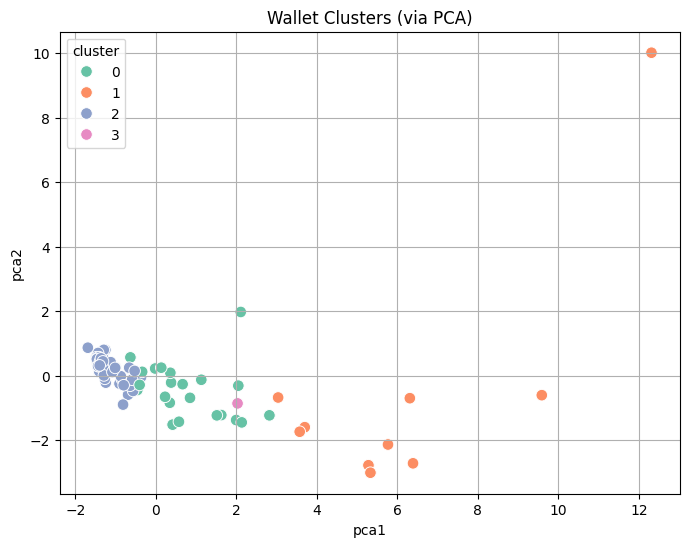

In [19]:
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

# Reduce to 2D for plotting
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Add PCA components to DataFrame
features_df['pca1'] = X_pca[:, 0]
features_df['pca2'] = X_pca[:, 1]

# Plot the clusters
plt.figure(figsize=(8,6))
sns.scatterplot(data=features_df, x='pca1', y='pca2', hue='cluster', palette='Set2', s=70)
plt.title('Wallet Clusters (via PCA)')
plt.grid(True)
plt.show()


The PCA (Principal Component Analysis) plot above visualizes the wallet clusters formed using K-Means clustering, reduced to two principal components (PCA1 and PCA2) for easy interpretation.

Cluster 1 (Orange): This cluster is the most widely spread and far from the others, indicating highly active wallets with large transaction volumes, high total value transferred, and possibly high risk. These could be institutional wallets or whales.

Cluster 0 (Green): This group represents moderately active wallets, with a decent number of successful transactions, moderate total value sent, and relatively stable gas usage. Likely represents regular but not extreme users.

Cluster 2 (Blue): These wallets show minimal activity, with low transaction counts, low total value, and fewer active days. These are likely low-risk or dormant wallets.

Cluster 3 (Pink): A very small group that may indicate anomalous behavior, such as high gas fees despite fewer transactions or irregular patterns. This could be due to spammy behavior or niche usage patterns.

Overall, the PCA plot confirms that the K-Means clustering has successfully grouped wallets with similar behavior. The clear separation between clusters suggests that the selected features are meaningful for identifying usage patterns and potential risk levels.



Final Risk Score Function

In [20]:
def assign_risk_score(cluster_label):
    if cluster_label == 1:
        return 900
    elif cluster_label == 0:
        return 700
    elif cluster_label == 2:
        return 800
    elif cluster_label == 3:
        return 400

features_df['risk_score'] = features_df['cluster'].apply(assign_risk_score)


risk score ka distribution

In [21]:
features_df['risk_score'].value_counts()


,count
risk_score,
800,67
700,22
900,10
400,1


Interpretation:
900: Very safe wallets (Cluster 1) – High activity, high success, large value.

800: Medium-risk wallets (Cluster 2) – Few transactions, low value.

700: Decent wallets (Cluster 0) – Moderate activity, low failure.

400: High-risk wallet (Cluster 3) – Highest number of failed transactions.

In [22]:
features_df[['wallet_id', 'cluster', 'risk_score']].head(10)


,wallet_id,cluster,risk_score
0,0x0039f22efb07a647557c7c5d17854cfd6d489ef3,2,800
1,0x06b51c6882b27cb05e712185531c1f74996dd988,2,800
2,0x0795732aacc448030ef374374eaae57d2965c16c,2,800
3,0x0aaa79f1a86bc8136cd0d1ca0d51964f4e3766f9,1,900
4,0x0fe383e5abc200055a7f391f94a5f5d1f844b9ae,2,800
5,0x104ae61d8d487ad689969a17807ddc338b445416,2,800
6,0x111c7208a7e2af345d36b6d4aace8740d61a3078,2,800
7,0x124853fecb522c57d9bd5c21231058696ca6d596,2,800
8,0x13b1c8b0e696aff8b4fee742119b549b605f3cbc,2,800
9,0x1656f1886c5ab634ac19568cd571bc72f385fdf7,0,700


 Visualization

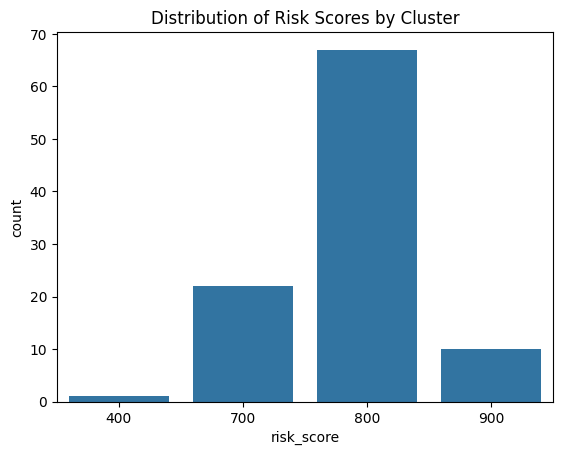

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=features_df, x='risk_score')
plt.title("Distribution of Risk Scores by Cluster")
plt.show()


CSV

In [24]:
features_df.to_csv("wallets_with_risk_scores.csv", index=False)


Risk Level (Low, Medium, High):



In [25]:
def label_risk(score):
    if score >= 900:
        return "Low Risk"
    elif score >= 800:
        return "Medium–Low Risk"
    elif score >= 700:
        return "Medium–High Risk"
    else:
        return "High Risk"

features_df["risk_label"] = features_df["risk_score"].apply(label_risk)


Risk Label Distribution Bar Chart

/tmp/ipython-input-26-2989007109.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="risk_label", data=features_df, palette="Set2")


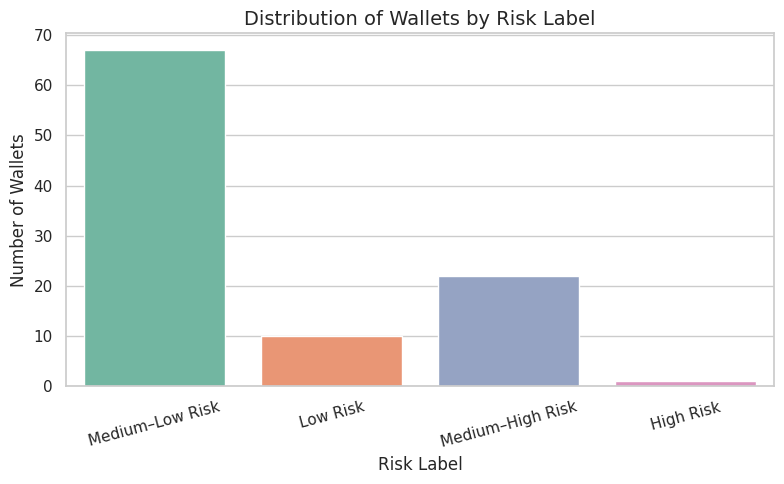

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")

# Plot
plt.figure(figsize=(8, 5))
sns.countplot(x="risk_label", data=features_df, palette="Set2")

# Titles and labels
plt.title("Distribution of Wallets by Risk Label", fontsize=14)
plt.xlabel("Risk Label", fontsize=12)
plt.ylabel("Number of Wallets", fontsize=12)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


Final Feature Table

In [27]:
final_df = features_df[["wallet_id", "cluster", "risk_score", "risk_label"] + list(features_df.columns.difference(["wallet_id", "cluster", "risk_score", "risk_label"]))]


Model Validation

In [28]:
from sklearn.metrics import silhouette_score

score = silhouette_score(X_scaled, kmeans.labels_)
print("Silhouette Score:", score)


Silhouette Score: 0.44597726860944314


Final CSV

In [29]:
# Final wallet_id and score
final_scores = features_df[['wallet_id', 'risk_score']]
final_scores.columns = ['wallet_id', 'score']  # rename to match required format

# Save to CSV
final_scores.to_csv("wallet_risk_scores_submission.csv", index=False)
